## Libraries

In [ ]:
# [IMPORTS] Core & Audio Processing
import os
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import copy

# [IMPORTS] Audio & Visualization
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

# [IMPORTS] PyTorch & ML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# [IMPORTS] Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

# [IMPORTS] Other
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')


## Dataset loading from google drive



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/drive/MyDrive/MuSE dataset/' /content

In [ ]:
# audio directory
audio_dir = '/content//MuSE dataset/audio/'
# labels directory
valence_dir = '/content/MuSE dataset/label_segments/valence/'
arousal_dir = '/content/MuSE dataset/label_segments/physio-arousal/'

audio_files = glob.glob(audio_dir + '*.wav')
print(f'Trovati {len(audio_files)} file audio.')

Trovati 97 file audio.


## Load and play one audio file

In [ ]:
# Load one audio file
audio_path = audio_files[0]
signal, sr = librosa.load(audio_path, sr=None)

# Listen to the file
print(f"Ascoltando: {os.path.basename(audio_path)} (durata: {len(signal)/sr:.2f} s)")
ipd.Audio(signal, rate=sr)

Ascoltando: 17_train.wav (durata: 60.00 s)


## Dataset Analysis

Calculate and normalize Mel-Spectrogram



In [ ]:
def mel_spectrogram(signal, sr, n_mels=128, n_fft=1024, hop_length=256, fmin=0, fmax=8000,
                    global_mean=None, global_std=None):
    mel_spec = librosa.feature.melspectrogram(
        y=signal, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, fmin=fmin, fmax=fmax, center=True
    )
    mel_db = librosa.power_to_db(mel_spec + 1e-6)

    if global_mean is not None and global_std is not None:
        global_std = np.where(global_std == 0, 1e-6, global_std)
        mel_norm = (mel_db - global_mean) / global_std
    else:
        mel_norm = mel_db

    return mel_norm.astype(np.float32)

Plot waveform and Mel-spectrogram

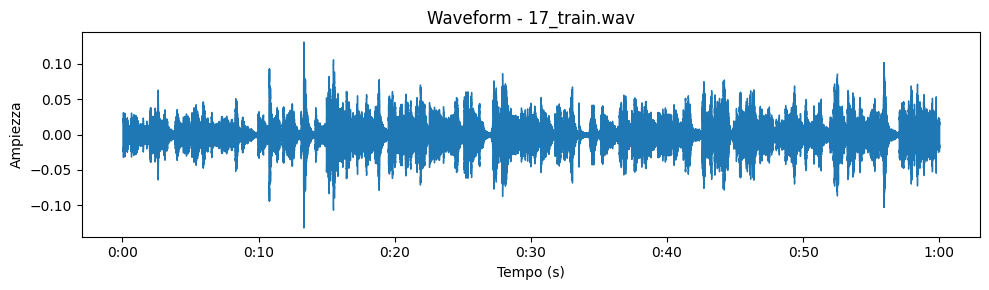

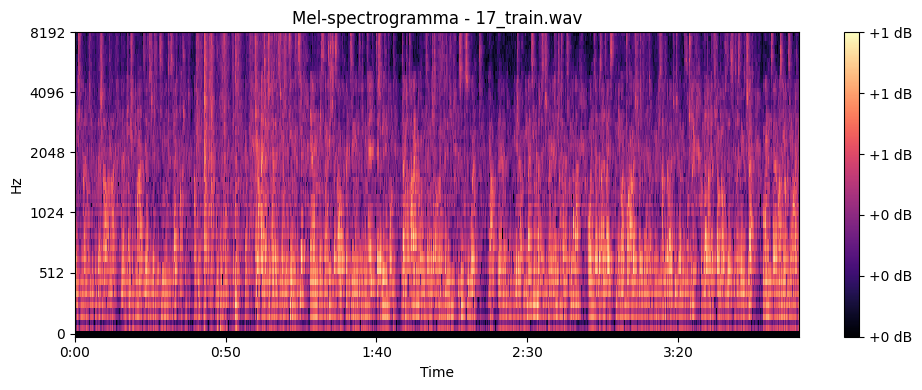

In [ ]:
def plot_waveform_and_mel(signal, sr, title=''):
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(signal, sr=sr)
    plt.title(f'Waveform - {title}')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Ampiezza')
    plt.tight_layout()
    plt.show()

    mel_db = mel_spectrogram(signal, sr)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-spectrogramma - {title}')
    plt.tight_layout()
    plt.show()

plot_waveform_and_mel(signal, sr, title=os.path.basename(audio_path))

## Dataset splitting

In [ ]:
random.seed(43)
np.random.seed(43)

# Ordina e shuffle
audio_files = sorted(audio_files)
random.shuffle(audio_files)

# Inizializziamo le liste per i diversi set
train_data = []       # <id>.wav
test_train_files = []  # <id>_train.wav
test_devel_files = []  # <id>_devel.wav

for file in audio_files:
    if file.endswith('_train.wav'):
        test_train_files.append(file)
    elif file.endswith('_devel.wav'):
        test_devel_files.append(file)
    elif '_' not in file and file.endswith('.wav'):
        train_data.append(file)

print(f"Train files found: {len(train_data)} file")
print(f"Test files found: {len(test_train_files)+len(test_devel_files)} file")

# Split interno (80-20)
train_files, devel_files = train_test_split(train_data, test_size=0.2, random_state=43)

# Test Set Preparation
test_files = test_train_files + test_devel_files

print(f"\nTrain dataset: {len(train_files)} file")
print(f"Devel dataset: {len(devel_files)} file")
print(f"Test  dataset: {len(test_files)} file")

Train files found: 55 file
Test files found: 28 file

Train dataset: 44 file
Devel dataset: 11 file
Test  dataset: 28 file


## Data Augmentation

In [ ]:
def augment_audio(signal, sr, prob_augment=0.5):
    if random.random() > prob_augment:
        return signal.copy()

    aug = random.choice(['noise', 'pitch', 'speed', 'volume'])
    signal = signal.copy()
    original_len = len(signal)

    if aug == 'noise':
        noise_factor = random.uniform(0.01, 0.05)
        noise = np.random.randn(len(signal))
        augmented_data = signal + noise_factor * noise

    elif aug == 'pitch':
        augmented_data = librosa.effects.pitch_shift(signal, sr=sr, n_steps=random.uniform(-2, 2))

    elif aug == 'speed':
        rate = random.uniform(0.85, 1.15)
        augmented_data = librosa.effects.time_stretch(signal, rate=rate)

    elif aug == 'volume':
        gain = random.uniform(0.9, 1.1)
        augmented_data = signal * gain

    if len(augmented_data) > original_len:
        augmented_data = augmented_data[:original_len]
    elif len(augmented_data) < original_len:
        augmented_data = np.pad(augmented_data, (0, original_len - len(augmented_data)), mode='constant')

    augmented_data = np.clip(augmented_data, -1.0, 1.0).astype(signal.dtype)
    return augmented_data


## Normalization

In [ ]:
def normalization(signal, target_dBFS=-3.0):
    if len(signal) == 0:
        return signal

    peak = np.max(np.abs(signal))
    if peak < 1e-10:
        return np.zeros_like(signal)

    current_dBFS = 20 * np.log10(peak)
    gain = target_dBFS - current_dBFS
    gain_linear = 10 ** (gain / 20)

    normalized_signal = signal * gain_linear
    normalized_signal = np.clip(normalized_signal, -1.0, 1.0)
    normalized_signal = np.nan_to_num(normalized_signal)

    return normalized_signal.astype(signal.dtype)


## Salvataggio Mel Spectrogrammi

In [ ]:
def compute_global_mean_std(audio_paths, valence_dir, arousal_dir, sr=16000, window_size_sec=0.5):
    seg_len = int(window_size_sec * sr)
    all_mels = []

    for path in tqdm(audio_paths):
        base = os.path.basename(path).replace('.wav','')
        val = pd.read_csv(os.path.join(valence_dir, f"{base}.csv"))['value'].values
        total_segments = len(val)

        sig, _ = librosa.load(path, sr=sr)

        for i in range(total_segments):
            start = i * seg_len
            end = start + seg_len
            seg = sig[start:end]
            if len(seg) < seg_len:
                seg = np.pad(seg, (0, seg_len - len(seg)))
            m = mel_spectrogram(seg, sr)
            all_mels.append(m)

    all_mels = np.concatenate(all_mels, axis=1)
    mean = np.mean(all_mels, axis=None)
    std = np.std(all_mels, axis=None)

    return mean, std

In [ ]:
def save_mel_sequences(
    audio_paths, valence_dir, arousal_dir, output_dir,
    sr=16000, window_size_sec=0.5, sequence_length=40,
    stride=10, apply_augmentation=True, augment_prob=1,
    global_mean=None, global_std=None
):
    os.makedirs(output_dir, exist_ok=True)
    seg_len = int(window_size_sec * sr)

    for path in audio_paths:
        base = os.path.basename(path).replace('.wav','')
        val = pd.read_csv(os.path.join(valence_dir, f"{base}.csv"))['value'].values
        aro = pd.read_csv(os.path.join(arousal_dir, f"{base}.csv"))['value'].values
        labels = np.stack([val, aro], axis=1)

        sig, _ = librosa.load(path, sr=sr)
        if global_std is not None:
            sig = normalization(sig, target_dBFS=-3)

        total_segments = len(labels)
        max_seq = total_segments - sequence_length + 1

        for i in range(0, max_seq, stride):
            audio_seq = sig[i*seg_len:(i+sequence_length)*seg_len]
            if len(audio_seq) < sequence_length * seg_len:
                audio_seq = np.pad(audio_seq, (0, sequence_length*seg_len - len(audio_seq)))

            def mk_mel_seq(audio):
                mels = []
                for j in range(sequence_length):
                    seg = audio[j*seg_len:(j+1)*seg_len]
                    mels.append(mel_spectrogram(seg, sr, global_mean=global_mean, global_std=global_std))
                arr = np.stack(mels).astype(np.float32)
                return arr[:, None, ...]

            mel_seq = mk_mel_seq(audio_seq)
            lbl_seq = labels[i:i+sequence_length]

            fn = f"{base}_seq{i:04d}.npz"
            np.savez_compressed(
                os.path.join(output_dir, fn),
                mel=mel_seq, label=lbl_seq
            )

            if apply_augmentation and random.random() < augment_prob:
                aug_seq = augment_audio(audio_seq, sr)
                mel_aug = mk_mel_seq(aug_seq)
                fn_aug = f"{base}_seq{i:04d}_aug.npz"
                np.savez_compressed(
                    os.path.join(output_dir, fn_aug),
                    mel=mel_aug, label=lbl_seq
                )

    print("Salvataggio completato in:", output_dir)

In [ ]:
def save_mean_std(mean, std, filepath):
    np.savez(filepath, mean=mean, std=std)
    print(f"Saved mean and std to {filepath}")


In [ ]:
def load_mean_std(filepath):
    data = np.load(filepath)
    mean = data['mean']
    std = data['std']
    print(f"Loaded mean and std from {filepath}")
    return mean, std


In [ ]:
# Calcolo mean e std
#global_mean, global_std = compute_global_mean_std(train_files, valence_dir, arousal_dir)

# Salvataggio su file
#save_mean_std(global_mean, global_std, 'global_mean_std.npz')

mean_loaded, std_loaded = load_mean_std('global_mean_std.npz')

save_mel_sequences(
    devel_files, valence_dir, arousal_dir, output_dir= './mel_sequences_val',
    sr=16000, window_size_sec=0.5, sequence_length=40, stride=1,
    apply_augmentation=False, augment_prob=1,
    global_mean=mean_loaded, global_std=std_loaded
)


Loaded mean and std from global_mean_std.npz
Salvataggio completato in: ./mel_sequences_val


In [ ]:
import shutil

shutil.make_archive("mel_sequences_valid", 'gztar', './mel_sequences_val')

'/content/mel_sequences_valid.tar.gz'